<a href="https://colab.research.google.com/github/HarmanDotpy/ML-Assignment2/blob/main/Q3_2Kmeans_SVHN_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import datasets
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
from torchvision.datasets import SVHN
import torch
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sb
import torch.nn.functional as F
from torchvision.datasets import SVHN
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def performance_metrics_multiclass(y_pred_test, y_test, num_class, disp_conf = True):
    '''gives the TPR, FPR, acc, precision, recall and F1 score for all classes by comparing the 2 input arrays'''
    #First we calculate the confusion matrix of size num_class*num_class
    #NOTE: Y axis of matrix will be predicted class and x axis wll be true class
    conf_mat = np.zeros((num_class, num_class))
    
    for i in range(num_class):
        for j in range(num_class):
            conf_mat[i, j] = np.logical_and(y_pred_test == i, y_test ==j).sum()
    # Calculating precision, recall, F1 Score for each class
    colnames = ['class', 'Precision', 'Recall', 'F1']
    df = pd.DataFrame(columns = colnames)
    for i in range(num_class):
        TP = conf_mat[i, i]
        FP = conf_mat[i].sum() - conf_mat[i, i]
        TN = conf_mat.sum() - conf_mat[i].sum() - conf_mat[:, i].sum() +  conf_mat[i, i]
        FN = conf_mat[:, i].sum() - conf_mat[i, i]
        P = round((TP)/(TP+FP), 5)
        R = round((TP)/(TP+FN), 5)
        F1 = round(2*P*R/(P+R), 5)
        df = df.append({'class':categories[i], 'Precision':P, 'Recall':R, 'F1':F1 }, ignore_index = True)
    macroF1 = round(df['F1'].mean(), 5)
    accuracy = round((y_pred_test==y_test).mean(), 5)
    
    # NOTE : returning the transpose of the confusion matricx to get true labels on the y axis
    conf_mat = conf_mat.T
    # NORMALIZING the confusion matrix
    conf_mat = np.around(conf_mat/(conf_mat.sum(axis = 1)), decimals = 5)
    # print(conf_mat.shape)
    
    #PLot the matrix if disp_conf = True
    if(disp_conf == True):
        ax = sb.heatmap(conf_mat, vmin = 0, vmax = 1, cmap = sb.light_palette("seagreen", as_cmap=True), xticklabels = categories, yticklabels = categories, annot = True, annot_kws={"size": 12}, fmt=".3f")
    #     ax.figure.axes[-1].yaxis.label.set_size(12)
        plt.xlabel('Predicted Labels', fontsize = 14)
        plt.ylabel('True Labels', fontsize = 14)
        plt.tick_params(axis='both', labelsize=10)
        return conf_mat, df, macroF1, accuracy, plt
    
    return conf_mat, df, macroF1, accuracy

Loading files containgin pca data of mnist and svhn , pca performed on fuilll dataset.
also loading tsne files.tsne had been performed on 10k images of svhn and 20k images of mnist

In [5]:
svhn_tsne = np.load('/content/svhn_tsne_numpy.npy')
svhn_pca = np.load('/content/svhn_pca4D_numpy.npy')
mnist_tsne = np.load('/content/mnist_tsne_numpy.npy')
mnist_pca = np.load('/content/mnist_pca4D_numpy.npy')

In [6]:
print(svhn_tsne.shape, mnist_tsne.shape, svhn_pca.shape, mnist_pca.shape)

(10000, 2) (20000, 2) (73257, 4) (60000, 4)


In [7]:
clusters = [3, 5, 10, 15, 20]
kmeans_svhn_tsne = {}
kmeans_svhn_pca = {}
kmeans_mnist_tsne = {}
kmeans_mnist_pca = {}

In [8]:
for num in clusters:
  kmeans_svhn_tsne[num] = KMeans(n_clusters=num, random_state=0).fit(svhn_tsne)
  kmeans_svhn_pca[num] = KMeans(n_clusters=num, random_state=0).fit(svhn_pca)
  kmeans_mnist_tsne[num] = KMeans(n_clusters=num, random_state=0).fit(mnist_tsne)
  kmeans_mnist_pca[num] = KMeans(n_clusters=num, random_state=0).fit(mnist_pca)

In [9]:
print(kmeans_svhn_tsne[3].labels_, kmeans_svhn_tsne[3].labels_.shape)

[1 0 0 ... 0 0 2] (10000,)


In [10]:
def normalize(data_tensor):
    '''re-scale image values to [-1, 1]'''
    return (data_tensor / 255.) * 2. - 1. 
    
transform_list = [transforms.ToTensor(), transforms.Lambda(lambda x: normalize(x))]


Classifier using 10k data and labels from SVHN tsne performed on 10k data

In [11]:
dataset = SVHN(root='data/', download=True,transform=transforms.Compose(transform_list))
# print(dataset.shape)

In [12]:
data_loader = DataLoader(dataset, batch_size = 10000, shuffle=True, num_workers=4, pin_memory=True)

In [13]:
X = next(iter(data_loader))[0]
# y_original
y = torch.Tensor(kmeans_svhn_tsne[3].labels_)
print(X.shape, y.shape)
X_train = X[:8000]
y_train = y[:8000]
X_test = X[8000:]
y_test = y[8000:]

torch.Size([10000, 3, 32, 32]) torch.Size([10000])


In [14]:
dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)
train_loader = DataLoader(dataset_train, batch_size = 128, shuffle = True, num_workers = 4, pin_memory = True)
test_loader = DataLoader(dataset_test, batch_size = X_test.shape[0], shuffle = True, num_workers = 4, pin_memory = True)

# Our Neural Network classifier for svhn dataset - LENET_Like architecture

In [25]:
class LeNet_Like(nn.Module):

    # network structure
    def __init__(self):
        super(LeNet_Like, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1   = nn.Linear(64*5*5, 1200)
        self.fc2   = nn.Linear(1200, 84)
        self.fc3   = nn.Linear(84, 3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        return np.prod(size)

class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size = 5, stride = 1, padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,stride = 2)
        )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64,kernel_size = 5, stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(7*7*64,1000)
    self.fc2 = nn.Linear(1000, 3)
    # self.softmax = nn.Softmax(dim = 0)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)    
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    # out = self.softmax(out)

    return out

In [26]:
# X_train_, y_train_ = svhn_tsne[0:8000], y[0:8000]
# X_test_, y_test_ = svhn_tsne[8000:], y[8000:]
# # X_train = 

# dataset_train = TensorDataset(X_train_, y_train_)
# dataset_test = TensorDataset(X_test_, y_test_)
# train_loader = DataLoader(dataset_train, batch_size = 128, shuffle = True, num_workers = 4, pin_memory = True)
# test_loader = DataLoader(dataset_test, batch_size = X_test_.shape[0], shuffle = True, num_workers = 4, pin_memory = True)

In [27]:
categories = ['{}'.format(i) for i in range(3)]
learning_rate = 0.001

In [28]:
#  initializing the model
# model = LeNet_Like()
model = ConvNet()
model = model.to(device)
criterion = nn.MSELoss(reduce = True)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
for name, param in model.named_parameters():
    print(name, param.size(), param.requires_grad)

layer1.0.weight torch.Size([32, 3, 5, 5]) True
layer1.0.bias torch.Size([32]) True
layer2.0.weight torch.Size([64, 32, 5, 5]) True
layer2.0.bias torch.Size([64]) True
fc1.weight torch.Size([1000, 3136]) True
fc1.bias torch.Size([1000]) True
fc2.weight torch.Size([3, 1000]) True
fc2.bias torch.Size([3]) True


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [29]:
# Training the model
totalsteps = len(train_loader)
losslist = []
accuracylist = []
num_epochs = 100
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    # FORWARD PROP, model(images) automatically calls forward
    # print(labels)
    outputs = model(images)
    # labels = torch.tensor(labels, dtype=torch.long, device=device)
    # print(outputs, labels)
    # loss = criterion(outputs, labels)
    # print(outputs, labels)
    loss = criterion(outputs, torch.nn.functional.one_hot(labels.long(), num_classes=3).to(torch.float32))

    losslist.append(loss.item())

    # BACK PROP
    # make the gradients zero
    optimizer.zero_grad() 
    # perform the backward propagation and get the gradients
    loss.backward()
    # adam optimizer training step . We use the gradients in this step
    optimizer.step()

    # Accuracy
    # Note we take batch_size amounts of y's at a time
    total = labels.size(0)
    # print(outputs, outputs.data)
    predicted = torch.max(outputs.data,1)[1]
    # print(outputs)
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    # accuracylist.append(accuracy)

    # item() is used for getting the scalar from a tensor
    if((i + 1) % 50 == 0):
    # if(True):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i+1, totalsteps, loss.item(),(accuracy)*100 ))

Epoch [1/100], Step [50/63], Loss: 0.2294, Accuracy: 33.59%
Epoch [2/100], Step [50/63], Loss: 0.2253, Accuracy: 29.69%
Epoch [3/100], Step [50/63], Loss: 0.2187, Accuracy: 41.41%
Epoch [4/100], Step [50/63], Loss: 0.2189, Accuracy: 43.75%
Epoch [5/100], Step [50/63], Loss: 0.2260, Accuracy: 33.59%
Epoch [6/100], Step [50/63], Loss: 0.2236, Accuracy: 35.16%
Epoch [7/100], Step [50/63], Loss: 0.2187, Accuracy: 42.97%
Epoch [8/100], Step [50/63], Loss: 0.2234, Accuracy: 36.72%
Epoch [9/100], Step [50/63], Loss: 0.2238, Accuracy: 39.84%
Epoch [10/100], Step [50/63], Loss: 0.2204, Accuracy: 42.19%
Epoch [11/100], Step [50/63], Loss: 0.2214, Accuracy: 39.06%
Epoch [12/100], Step [50/63], Loss: 0.2231, Accuracy: 35.16%
Epoch [13/100], Step [50/63], Loss: 0.2231, Accuracy: 33.59%
Epoch [14/100], Step [50/63], Loss: 0.2203, Accuracy: 39.06%
Epoch [15/100], Step [50/63], Loss: 0.2191, Accuracy: 42.19%
Epoch [16/100], Step [50/63], Loss: 0.2212, Accuracy: 38.28%
Epoch [17/100], Step [50/63], Los

KeyboardInterrupt: ignored

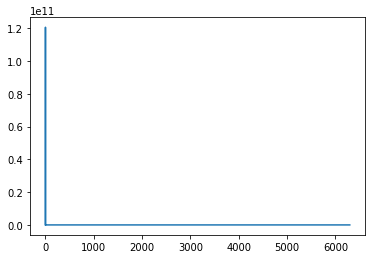

In [123]:
plt.plot(losslist)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


(3, 3)
[[0.      0.85206 0.     ]
 [0.      1.      0.     ]
 [0.      0.99289 0.     ]]
   class  Precision  Recall       F1
0    0.0        NaN     0.0      NaN
1    1.0     0.3515     1.0  0.52016
2    2.0        NaN     0.0      NaN
macroF1 = 0.52016, accuracy = 0.3515
Test Accuracy for 2000 test images = 35.15 %


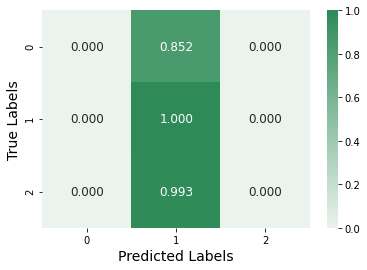

In [124]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  # The following loop runs only for 1 time as the batch size for test loader is the size of number of test images only
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.max(outputs.data,1)[1]
    categories = [i for i in range(3)]
    confmat, df, macrof1, acc, plt = performance_metrics_multiclass(predicted.to('cpu').numpy(), labels.to('cpu').numpy(), num_class=3)
    print(confmat)
    print(df)
    print('macroF1 = {}, accuracy = {}'.format(macrof1, acc))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Test Accuracy for {} test images = {} %'.format(len(test_loader.dataset) ,(correct/total)*100))

  # torch.save(model.state_dict(), './MODEL_STORE/MNIST_conve_nets.ckpt')


  ##Performance metrics


# SVM as classifier

In [40]:
for cluster in clusters:
  print('FOR {} Clusters'.format(cluster))

  y = kmeans_svhn_tsne[cluster].labels_

  X_train_, y_train_ = svhn_tsne[0:8000], y[0:8000]
  X_test_, y_test_ = svhn_tsne[8000:], y[8000:]

  clf = svm.SVC(kernel='poly', degree = 1, C = 1)
  clf.fit(X_train_, y_train_)

  y_pred_test = clf.predict(X_test_)
  y_pred_train = clf.predict(X_train_)

  print(classification_report(y_test_, y_pred_test, digits = 4))
  print(classification_report(y_train_, y_pred_train, digits = 4))

FOR 3 Clusters
              precision    recall  f1-score   support

           0     0.9967    0.9950    0.9958       599
           1     0.9958    1.0000    0.9979       703
           2     1.0000    0.9971    0.9986       698

    accuracy                         0.9975      2000
   macro avg     0.9975    0.9974    0.9974      2000
weighted avg     0.9975    0.9975    0.9975      2000

              precision    recall  f1-score   support

           0     0.9971    0.9913    0.9942      2417
           1     0.9918    0.9993    0.9956      3029
           2     0.9996    0.9961    0.9978      2554

    accuracy                         0.9959      8000
   macro avg     0.9962    0.9956    0.9959      8000
weighted avg     0.9959    0.9959    0.9959      8000

FOR 5 Clusters
              precision    recall  f1-score   support

           0     0.9636    0.9973    0.9802       372
           1     0.9922    1.0000    0.9961       381
           2     0.9974    0.9898    0.9936  